In [1]:


import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import random
import matplotlib.patches as patches
import numpy as np
from scipy import integrate
from scipy.optimize import fsolve
import os,matplotlib
import time,pickle,_pickle
import matplotlib.pyplot as plt
from matplotlib.pylab import rc
import os
import h5py
import math
import os.path
import tensorflow as tf
import keras

import pickle
tf.enable_eager_execution()
tf.VERSION
AUTOTUNE = tf.data.experimental.AUTOTUNE


omega_m = 0.272
omega_gamma = 0.728

def redshift_to_Dc(z):
    return integrate.quad(lambda x: 3000 * ((1 + x) ** 3 * omega_m + omega_gamma) ** (-0.5), 0, z)[0]


redshift_to_Dc = np.vectorize(redshift_to_Dc)


def log10(x):
    if x > 0:
        return math.log10(x)
    else:
        return np.nan

def box_smooth(data_array):
    N = len(data_array)

    data_smooth = []

    for i in range(0, N):
        data_i = data_array[int(np.maximum(i - 1, 0)):int(np.minimum(i + 2, N))]
        # print(np.nanmean(data_i))

        data_smooth.append(np.nanmean(data_i))

    data_smooth = np.array(data_smooth).ravel()
    data_smooth[0] = np.nanmedian(data_array[:1])
    return data_smooth

def bootstrap_scatter_err(samples):
    mask_finite = np.isfinite(samples)
    samples = samples[mask_finite]
    index_all = range(len(samples))
    err_all = []
    N=100
    for i in range(0,N):
        index_choose = np.random.randint(0,len(samples)-1,len(samples))
        # k_i = np.nanstd(samples[index_choose])
        k_i = np.percentile(samples[index_choose],84)-np.percentile(samples[index_choose],16)
        k_i = k_i/2
        err_all.append(k_i)
    err_all = np.array(err_all)
    if len(samples)<0:
        err_all = np.nan

    return err_all


def exp(x):
    try:
        return math.exp(x)
    except:
        return np.inf

def Mpeak_log_to_Vpeak_log(Mpeak_log):
    return 0.3349*Mpeak_log - 1.672

G = 4.301 * 10 ** (-9)
cons = (4 * G * np.pi / (3 * (1 / 24 / (1.5 * 10 ** (11))) ** (1 / 3))) ** 0.5


def calculate_v_dispersion(Mh):
    return Mh ** (1 / 3) * cons


exp = np.vectorize(exp)
log10 = np.vectorize(log10)



plot_path = "/Users/caojunzhi/Downloads/upload_201906_Jeremy/"


if os.path.isdir("/Volumes/SSHD_2TB") == True:
    print("The code is on Spear of Adun")

    ## Move to Data_10TB
    data_path = "/Volumes/Data_10TB/"

elif os.path.isdir("/mount/sirocco1/jc6933/test") == True:
    data_path = "/mount/sirocco2/jc6933/Data_sirocco/"
    print("The code is on Sirocco")

# Kratos
elif os.path.isdir("/home/jc6933/test_kratos") == True:
    data_path = "/mount/kratos/jc6933/Data/"
    print("The code is on Kratos")

# Void Seeker
elif os.path.isdir("/home/jc6933/test_Void_Seeker") == True:
    data_path = "/mount/Void_Seeker/Data_remote/"
    print("The code is on Void Seeker")

### PRINCE:
elif os.path.isdir("/home/jc6933/test_folder_prince") == True:
    data_path = "/scratch/jc6933/"
    print("The code is on PRINCE")

else:
    print("The code is on local")
    data_path = "/Volumes/Extreme_SSD/Data/"

print("data_path %s" % data_path)

# import C250 data:
hf_Bolshoi = h5py.File(data_path + "C250_with_concentration.h5", "r")

data_Bolshoi = np.array(hf_Bolshoi["dataset"])[:, 1:7]
Mpeak = np.array(hf_Bolshoi["Mpeak"])
Mvir = np.array(hf_Bolshoi["M_vir"])
Vpeak = np.array(hf_Bolshoi["Vpeak"])
upid = np.array(hf_Bolshoi["upid"], dtype=int)
pid = np.array(hf_Bolshoi["pid"], dtype=int)
id = np.array(hf_Bolshoi["id"], dtype=int)
halo_concentration = np.array(hf_Bolshoi["halo_concentration"], dtype=float)
Acc_Rate_Inst = np.array(hf_Bolshoi["Acc_Rate_Inst"], dtype=float)

print(list(hf_Bolshoi.keys()))

hf_Bolshoi.close()

Mvir_log = log10(Mvir)

pkl_file = open(data_path + "R_vir_z0_C250.pkl", 'rb')
R_vir = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(data_path + "Mpeak/" + "Ms_log_C250_M_peak_combined_v1.pkl", 'rb')
Ms_all_log = pickle.load(pkl_file)
pkl_file.close()

L_log_array = pickle.load(open(data_path+"SHAM_L_double_Schechter/L_C250_v1.pkl","rb"))
# add scatter to L_log_array:

## Add velocity dispersion:
# It's good and we reach 93%!!!

pkl_file = open(data_path + "Vrms_C250.pkl", 'rb')
Vrms = pickle.load(pkl_file)
pkl_file.close()

L_log_array = L_log_array+np.random.normal(0,0.2,len(L_log_array))

print("Finish loading data")
### Let's use 5 layer NN and do binary-cross entropy on upid:
## convert to RA DEC and z and add Luminosity to features
# use 0,0,0 or 125,125,125? as or OB location, which is the same as the Luminosity draft:
# I want to use 125,125,125
## convert to RA DEC and z:

distance =250
func_distance_to_z = lambda z: redshift_to_Dc(z)-distance
root = fsolve(func_distance_to_z,0.1)
print(root)

# return r, dec and RA in radian
def convert_Cartesian_to_spherical(x,y,z):
    r = (x**2+y**2+z**2)**0.5

    # DEC
    theta = np.arccos(z/r)
    # RA
    phi = np.arctan2(y, x)

    return r,theta,phi

## convert coordinate:

data_Bolshoi = data_Bolshoi[:,:3]+data_Bolshoi[:,3:6]/(1e5)


r,DEC_array,RA_array = convert_Cartesian_to_spherical(x=data_Bolshoi[:,0],y=data_Bolshoi[:,1],z=data_Bolshoi[:,2])

redshift_array = r/(3*1e3)


##### normalize data to -1 to 1!!!


def normalize(x):
    return 2*(x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))-1


## features:
# RA DEC Z, Mh, Ms, L
 # remember to normalzie them:

mask_90 = Ms_all_log>9.0

RA_norm = normalize(RA_array[mask_90])
DEC_norm = normalize(DEC_array[mask_90])
z_norm = normalize(redshift_array[mask_90])

Mh_norm = normalize(Mvir_log[mask_90])
Ms_norm = normalize(Ms_all_log[mask_90])
L_norm = normalize(L_log_array[mask_90])
R_vir_norm = normalize(R_vir[mask_90])
Vpeak_norm = normalize(Vpeak[mask_90])
Vrms_norm = normalize(Vrms[mask_90])
halo_concentration_norm = normalize(halo_concentration[mask_90])


## no RA DEC or z!!
label_names = ["Vpeak","halo_concentration","Ms","L","R_vir","Vrms"]

upid_norm = upid
mask_upid = upid>0
upid_norm[mask_upid] = 1

mask_upid = upid<0
upid_norm[mask_upid] = 0

# Also remove redshift!!

X = np.c_[Vpeak_norm,halo_concentration_norm,Ms_norm,L_norm,R_vir_norm,Vrms_norm]
Y = upid_norm[mask_90]

fusion=np.c_[X,Y]


# split into 8:2 train test:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,Y, test_size=0.2,shuffle=True)


Using TensorFlow backend.


The code is on Void Seeker
data_path /mount/Void_Seeker/Data_remote/
['Acc_Rate_Inst', 'M_vir', 'Mpeak', 'V_max', 'Vpeak', 'dataset', 'halo_concentration', 'header', 'id', 'pid', 'upid']
Finish loading data
[0.08483107]


Time it takes using GPU=47.11
Good=55124 Bad=4294
Accuracy=0.93 for testing set


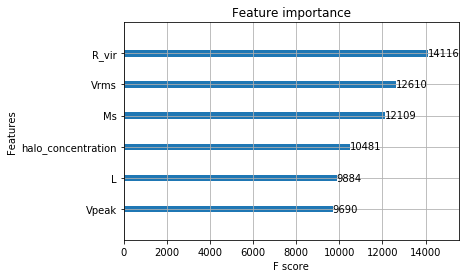

In [2]:

### XGBOOST:
import time
# try xgboost:
from xgboost import XGBClassifier
from xgboost import plot_importance
import pandas as pd


time_start = time.time()
params={}
params['gpu_id'] = 0
params['max_bin'] = 1024
params['tree_method'] = 'gpu_hist'
model = XGBClassifier(n_estimators=10000,verbose=2,n_jobs=-1,**params)
X_train = pd.DataFrame(data=X_train, columns=label_names)
model.fit(X_train,y_train)
# predict:


print("Time it takes using GPU=%.2f"%(time.time()-time_start))


X_test = pd.DataFrame(data=X_test, columns=label_names)
Y_predict_test = model.predict(X_test)

mask_good = abs(Y_predict_test-y_test)<0.01

print("Good=%d Bad=%d"%(len(Y_predict_test[mask_good]),len(Y_predict_test)-len(Y_predict_test[mask_good])))

print("Accuracy=%.2f for testing set"%(len(Y_predict_test[mask_good])/len(Y_predict_test)))


## plot importance:
plot_importance(model)



#%%

%matplotlib inline

#%%

plot_importance(model)

#%%



W0802 18:03:39.138278 139925942306624 deprecation.py:323] From /home/jc6933/anaconda3/envs/tf14/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               700       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2

AttributeError: 'History' object has no attribute 'keys'

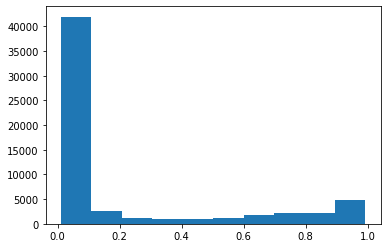

In [3]:


# split into 8:2 train test:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,Y, test_size=0.2,shuffle=True)



# A simple example of Neural network. This basic neural network doesn't include any
model = tf.keras.Sequential([
  tf.keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X.shape[1],)),  # must declare input shape
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Dense(50,activation="sigmoid"),
    tf.keras.layers.Dropout(rate=0.1),
tf.keras.layers.Dense(25,activation="sigmoid"),
tf.keras.layers.Dropout(rate=0.1),
tf.keras.layers.Dense(10,activation="sigmoid")
  # Add dropout

])
# third layer
# 2 output labels: -1 for host-halo and 1 for subhalo
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))




# adam for Gradient boost
model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])


model.summary()

print(len(y_train))


# train it:
batch_size = 256


#X_train = tf.convert_to_tensor(X_train)
#y_train = tf.convert_to_tensor(y_train)
# batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. Do not specify the batch_size if your data is in the form of symbolic tensors, dataset, dataset iterators, generators, or keras.utils.Sequence instances (since they generate batches).
### Avoid nan values
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
X_train = my_imputer.fit_transform(X_train)

X_test = my_imputer.fit_transform(X_test)
int_step = int(len(y_train)/batch_size)+1

# 10 is good enough
num_steps=10
training_history = model.fit(X_train,y_train,validation_split=0.1,batch_size=batch_size, epochs=num_steps,steps_per_epoch=int_step,shuffle=True)

print(training_history.history.keys())
## test:
y_p = model.predict_classes(X_test).ravel()
mask_good = abs(y_p-y_test)<0.05
print(len(y_test[mask_good]),len(y_test))


print("Validation")

Y_predict_test = model.predict_classes(X_test)
Y_predict_test = Y_predict_test.ravel()
mask_good = abs(Y_predict_test-y_test)<0.01

print("Good=%d Bad=%d"%(len(Y_predict_test[mask_good]),len(Y_predict_test)-len(Y_predict_test[mask_good])))

print("Accuracy=%.2f for testing set"%(len(Y_predict_test[mask_good])/len(Y_predict_test)))

## regressor on P!:
Probability = model.predict(X_test)
plt.hist(Probability.ravel())






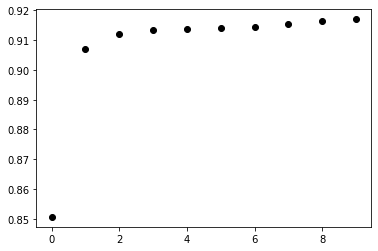

In [8]:
#%%

## plot the history of accuracy:
training_history.history.keys()

plt.plot(training_history.history['acc'],"ko")



AUC: 0.9465


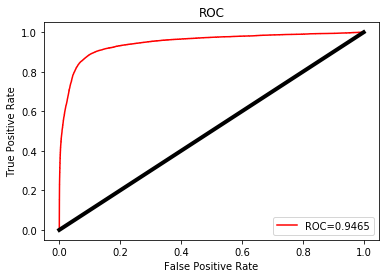

In [11]:

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


def confusion_matrix(y_pred, y_true):
    TP = len(y_pred[(y_pred == 1) & (y_true == 1)])
    TN = len(y_pred[(y_pred == 1) & (y_true == 0)])
    # type1 error : false alarm
    FP = len(y_pred[(y_pred == 1) & (y_true == 0)])
    # type 2 error. Fail to make alarm
    FN = len(y_pred[(y_pred == 0) & (y_true == 1)])

    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    accuracy = (TP + TN) / len(y_pred)

    f1_score = 2 / (1 / precision + 1 / recall)
    return TP, TN, FP, FN, recall, precision, accuracy, f1_score


testy = y_test
prob = model.predict(X_test)
probs = prob

auc = roc_auc_score(testy, probs)
print('AUC: %.4f' % auc)

## draw ROC:
fpr, tpr, thresholds = roc_curve(testy, probs)

plt.plot(fpr, tpr, color='r', label='ROC=%.4f' % auc)
plt.plot([0, 1], [0, 1], color='k', linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()
